In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)


/kaggle/working


In [3]:
# necessary libraries 
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, Concatenate
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-11 20:00:10.135662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749672010.477482      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749672010.582656      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [5]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [6]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [7]:
# # Filter for patients with both CC and MLO views
# def get_paired_samples(df):
#     # Group by patient_id and ensure both CC and MLO views exist
#     grouped = df.groupby('patient_id').filter(lambda x: set(x['image_view']) == {'CC', 'MLO'})
#     return grouped

In [8]:
# # Filter for patients with exactly one CC and one MLO view
# def get_paired_samples(df):
#     # Group by patient_id and ensure both CC and MLO views exist
#     grouped = df.groupby('patient_id').filter(lambda x: set(x['image_view']) == {'CC', 'MLO'})
    
#     # For each patient, select one CC and one MLO view (e.g., first occurrence)
#     cc_views = grouped[grouped['image_view'] == 'CC'].groupby('patient_id').first().reset_index()
#     mlo_views = grouped[grouped['image_view'] == 'MLO'].groupby('patient_id').first().reset_index()
    
#     # Ensure only patients present in both CC and MLO are kept
#     common_patients = np.intersect1d(cc_views['patient_id'], mlo_views['patient_id'])
#     cc_views = cc_views[cc_views['patient_id'].isin(common_patients)].sort_values('patient_id').reset_index(drop=True)
#     mlo_views = mlo_views[mlo_views['patient_id'].isin(common_patients)].sort_values('patient_id').reset_index(drop=True)
    
#     return cc_views, mlo_views

In [9]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [10]:
# check paths
print("Cropped Image Path: ", cropped_images.iloc[0])
print("FULL Mammogram Path: ", full_mammogram.iloc[0])
print("ROI MASK Path: ", roi_mask.iloc[0])


Cropped Image Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
FULL Mammogram Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI MASK Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [11]:
# Replace the path for cropped_images to the correct directory.
correct_dir = "../input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.


# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.



Cropped Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[4]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")


cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)



list(cropped_images_dict.items())[:5]


list(full_mammo_dict.items())[:5]

list(roi_img_dict.items())[:5]


the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


[('1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091/2-127.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.357008050412534761329866492500201501919',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.35700805041253476132986649250020150191

In [13]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

In [14]:
fix_image_path_mass(mass_train)
fix_image_path_mass(mass_test)


In [15]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns 
mass_train.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [16]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns 
mass_test.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [17]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [18]:

mass_test.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [19]:
mass_train.image_file_path[0]

'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'

In [20]:
mass_test.image_file_path[0]

'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/1-271.jpg'

In [21]:
mass_train[['image_file_path', 'image_view']].head()


,image_file_path,image_view
0,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
1,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
2,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
3,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
4,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO


In [22]:
mass_test[['image_file_path', 'image_view']].head()

,image_file_path,image_view
0,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
1,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
2,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
3,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
4,../input/cbis-ddsm-breast-cancer-image-dataset...,CC


In [23]:
# Fixed function to get properly paired CC and MLO samples
def get_paired_samples(df):
    """
    Filter for patients with exactly one CC and one MLO view.
    Returns two aligned dataframes: cc_views and mlo_views
    """
    # Group by patient_id and ensure both CC and MLO views exist
    grouped = df.groupby('patient_id').filter(lambda x: set(x['image_view']) == {'CC', 'MLO'})
    
    # For each patient, select one CC and one MLO view (first occurrence of each)
    cc_views = grouped[grouped['image_view'] == 'CC'].groupby('patient_id').first().reset_index()
    mlo_views = grouped[grouped['image_view'] == 'MLO'].groupby('patient_id').first().reset_index()
    
    # Ensure only patients present in both CC and MLO are kept
    common_patients = np.intersect1d(cc_views['patient_id'], mlo_views['patient_id'])
    cc_views = cc_views[cc_views['patient_id'].isin(common_patients)].sort_values('patient_id').reset_index(drop=True)
    mlo_views = mlo_views[mlo_views['patient_id'].isin(common_patients)].sort_values('patient_id').reset_index(drop=True)
    
    return cc_views, mlo_views

# Apply the corrected function
mass_train_cc, mass_train_mlo = get_paired_samples(mass_train)
mass_test_cc, mass_test_mlo = get_paired_samples(mass_test)

# Now verify alignment (this should work without errors)
print(f"Train CC samples: {len(mass_train_cc)}")
print(f"Train MLO samples: {len(mass_train_mlo)}")
print(f"Test CC samples: {len(mass_test_cc)}")
print(f"Test MLO samples: {len(mass_test_mlo)}")

# Verify alignment
assert len(mass_train_cc) == len(mass_train_mlo), f"Train lengths mismatched: CC={len(mass_train_cc)}, MLO={len(mass_train_mlo)}"
assert len(mass_test_cc) == len(mass_test_mlo), f"Test lengths mismatched: CC={len(mass_test_cc)}, MLO={len(mass_test_mlo)}"

assert (mass_train_cc['patient_id'].values == mass_train_mlo['patient_id'].values).all(), "Train patient IDs misaligned"
assert (mass_test_cc['patient_id'].values == mass_test_mlo['patient_id'].values).all(), "Test patient IDs misaligned"

print("✅ All alignment checks passed!")

# Display some statistics
print(f"\nTraining patients with paired CC/MLO views: {len(mass_train_cc)}")
print(f"Testing patients with paired CC/MLO views: {len(mass_test_cc)}")

# Show sample of aligned data
print("\n--- Sample of aligned training data ---")
print("CC views:")
print(mass_train_cc[['patient_id', 'image_view', 'pathology']].head())
print("\nMLO views:")
print(mass_train_mlo[['patient_id', 'image_view', 'pathology']].head())

Train CC samples: 490
Train MLO samples: 490
Test CC samples: 146
Test MLO samples: 146
✅ All alignment checks passed!

Training patients with paired CC/MLO views: 490
Testing patients with paired CC/MLO views: 146

--- Sample of aligned training data ---
CC views:
  patient_id image_view  pathology
0    P_00001         CC  MALIGNANT
1    P_00004         CC     BENIGN
2    P_00009         CC  MALIGNANT
3    P_00018         CC     BENIGN
4    P_00021         CC     BENIGN

MLO views:
  patient_id image_view  pathology
0    P_00001        MLO  MALIGNANT
1    P_00004        MLO     BENIGN
2    P_00009        MLO  MALIGNANT
3    P_00018        MLO     BENIGN
4    P_00021        MLO     BENIGN


In [24]:
# Map pathology to binary labels (MALIGNANT = 1, BENIGN/BENIGN_WITHOUT_CALLBACK = 0)
mass_train_cc['label'] = mass_train_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_train_mlo['label'] = mass_train_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_cc['label'] = mass_test_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_mlo['label'] = mass_test_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')


In [25]:
        print("mass_train_cc after mapping:")
        print(mass_train_cc[['pathology', 'label']].head())  # Show pathology and label columns

        print("\nmass_train_mlo after mapping:")
        print(mass_train_mlo[['pathology', 'label']].head())

        # ... repeat for test sets
        print("mass_train_cc after mapping:")
        print(mass_test_cc[['pathology', 'label']].head())  # Show pathology and label columns

        print("\nmass_train_mlo after mapping:")
        print(mass_test_mlo[['pathology', 'label']].head())

mass_train_cc after mapping:
   pathology label
0  MALIGNANT     1
1     BENIGN     0
2  MALIGNANT     1
3     BENIGN     0
4     BENIGN     0

mass_train_mlo after mapping:
   pathology label
0  MALIGNANT     1
1     BENIGN     0
2  MALIGNANT     1
3     BENIGN     0
4     BENIGN     0
mass_train_cc after mapping:
   pathology label
0  MALIGNANT     1
1  MALIGNANT     1
2     BENIGN     0
3  MALIGNANT     1
4  MALIGNANT     1

mass_train_mlo after mapping:
   pathology label
0  MALIGNANT     1
1  MALIGNANT     1
2     BENIGN     0
3  MALIGNANT     1
4  MALIGNANT     1


In [26]:
# Confirm distribution
print("CC Training label counts:\n", mass_train_cc['label'].value_counts())
print("CC Testing label counts:\n", mass_test_cc['label'].value_counts())


# Confirm distribution
print("MLO Training label counts:\n", mass_train_mlo['label'].value_counts())
print("MLO Testing label counts:\n", mass_test_mlo['label'].value_counts())


CC Training label counts:
 label
0    246
1    244
Name: count, dtype: int64
CC Testing label counts:
 label
0    87
1    59
Name: count, dtype: int64
MLO Training label counts:
 label
0    247
1    243
Name: count, dtype: int64
MLO Testing label counts:
 label
0    87
1    59
Name: count, dtype: int64


In [27]:
# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_cc = train_datagen.flow_from_dataframe(
    dataframe=mass_train_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True
)

# Test generator
test_generator_cc = test_datagen.flow_from_dataframe(
    dataframe=mass_test_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# use only cropped_image_path (just misses out on important anatomical details)

# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_mlo = train_datagen.flow_from_dataframe(
    dataframe=mass_train_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True
)



# Test generator
test_generator_mlo = test_datagen.flow_from_dataframe(
    dataframe=mass_test_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)







Found 490 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.
Found 490 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.


In [28]:
# feature vectors model 

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D




def build_EffB0_feature_extractor_cc(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze last unfreeze_ratio% of layers (same as MLO)
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True
    
    x_cc = GlobalAveragePooling2D()(base_model.output)
    x_cc = Dense(512, activation='relu')(x_cc)
    x_cc =BatchNormalization()(x_cc)
    output = Dropout(0.4)(x_cc)


    # binary classification to check model performance ()
    # x_cc = Dropout(0.4)(x_cc)
    # output = Dense(1, activation='sigmoid')(x_cc)  #Binary classification
    
    # return Model(inputs=base_model.input, outputs=output)
    return Model(inputs=base_model.input, outputs=output, name='cc_feature_extractor')





# Build model
EffB0_model_cc = build_EffB0_feature_extractor_cc()
# EffB0_model_cc.summary()

                              
                             

2025-06-11 20:00:38.906847: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:

# Just get the features
cc_feature_vectors_train = EffB0_model_cc.predict(train_generator_cc, verbose=1)
cc_feature_vectors_test = EffB0_model_cc.predict(test_generator_cc, verbose=1)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [30]:
np.save("cc_feature_vectors_train.npy", cc_feature_vectors_train)
np.save("cc_feature_vectors_test.npy", cc_feature_vectors_test)



In [31]:
def build_EffB0_feature_extractor_mlo(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.models import Model

    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last unfreeze_ratio% of layers
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True

    # Classification head
    x_mlo = GlobalAveragePooling2D()(base_model.output)
    x_mlo = Dense(512, activation='relu')(x_mlo)
    x_mlo =BatchNormalization()(x_mlo)  # Normalizes 512 features
    output = Dropout(0.4)(x_mlo)
    
    
    # binary classification to check model performance ()
    # x_mlo = Dropout(0.4)(x_mlo)
    # output = Dense(1, activation='sigmoid')(x_mlo)  #Binary classification

    # return Model(inputs=base_model.input, outputs=output)
    
    return Model(inputs=base_model.input, outputs=output, name='mlo_feature_extractor')


# Build model
EffB0_model_mlo = build_EffB0_feature_extractor_mlo()
# EffB0_model_mlo.summary()

In [32]:

# Just get the features
mlo_feature_vectors_train = EffB0_model_mlo.predict(train_generator_mlo, verbose=1)
mlo_feature_vectors_test = EffB0_model_mlo.predict(test_generator_mlo, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [33]:
np.save("mlo_feature_vectors_train.npy", mlo_feature_vectors_train)
np.save("mlo_feature_vectors_test.npy", mlo_feature_vectors_test)

In [34]:
print(f"cc_feature_vectors_train shape: {cc_feature_vectors_train.shape}")
print(f"mlo_feature_vectors_train shape: {mlo_feature_vectors_train.shape}")
print(f"cc_feature_vectors_test shape: {cc_feature_vectors_test.shape}")
print(f"mlo_feature_vectors_test shape: {mlo_feature_vectors_test.shape}")
    

cc_feature_vectors_train shape: (490, 512)
mlo_feature_vectors_train shape: (490, 512)
cc_feature_vectors_test shape: (146, 512)
mlo_feature_vectors_test shape: (146, 512)


In [35]:
# Load the saved feature vectors
cc_feature_vectors_train = np.load("cc_feature_vectors_train.npy")
mlo_feature_vectors_train = np.load("mlo_feature_vectors_train.npy")
cc_feature_vectors_test = np.load("cc_feature_vectors_test.npy")
mlo_feature_vectors_test = np.load("mlo_feature_vectors_test.npy")

# Get labels from the dataframes
train_labels = mass_train_cc['label'].values.astype(np.float32)  # Assuming labels are aligned
test_labels = mass_test_cc['label'].values.astype(np.float32)

# Verify shapes
print(f"CC Train Features Shape: {cc_feature_vectors_train.shape}")
print(f"MLO Train Features Shape: {mlo_feature_vectors_train.shape}")
print(f"CC Test Features Shape: {cc_feature_vectors_test.shape}")
print(f"MLO Test Features Shape: {mlo_feature_vectors_test.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

CC Train Features Shape: (490, 512)
MLO Train Features Shape: (490, 512)
CC Test Features Shape: (146, 512)
MLO Test Features Shape: (146, 512)
Train Labels Shape: (490,)
Test Labels Shape: (146,)


In [36]:
# Define the dual-view classifier
def build_dual_view_classifier():
    # Input layers for CC and MLO feature vectors
    cc_input = Input(shape=(512,), name='cc_input')
    mlo_input = Input(shape=(512,), name='mlo_input')
    
    # Concatenate the CC and MLO feature vectors
    combined = Concatenate()([cc_input, mlo_input])
    
    # Add dense layers for classification
    x = Dense(256, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    # Create the model
    model = Model(inputs=[cc_input, mlo_input], outputs=output, name='dual_view_classifier')
    return model

In [37]:
# Build the model
dual_view_model = build_dual_view_classifier()

# Compile the model
dual_view_model.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [38]:
dual_view_model.summary()

Model: "dual_view_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cc_input (InputLayer)     │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlo_input (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ cc_input[0][0],        │
│                           │                        │                │ mlo_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        262,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 296,961 (1.13 MB)

 Trainable params: 296,193 (1.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [39]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = dual_view_model.fit(
    [cc_feature_vectors_train, mlo_feature_vectors_train],  # Inputs: CC and MLO features
    train_labels,  # Labels
    validation_data=([cc_feature_vectors_test, mlo_feature_vectors_test], test_labels),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5194 - auc: 0.5321 - loss: 0.7196 - val_accuracy: 0.5959 - val_auc: 0.5000 - val_loss: 0.6823
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5381 - auc: 0.5319 - loss: 0.7283 - val_accuracy: 0.5959 - val_auc: 0.5000 - val_loss: 0.6818
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5565 - auc: 0.5759 - loss: 0.7104 - val_accuracy: 0.5959 - val_auc: 0.4539 - val_loss: 0.6905
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5089 - auc: 0.5600 - loss: 0.7084 - val_accuracy: 0.5959 - val_auc: 0.5000 - val_loss: 0.6879
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5091 - auc: 0.5340 - loss: 0.7210 - val_accuracy: 0.5959 - val_auc: 0.5000 - val_loss: 0.6835
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5581 - auc: 0.5735 - loss: 0.7099 - val_accuracy: 0.5959 - val_auc: 0.5082 - val_loss: 0.6745
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test AUC: 0.5690


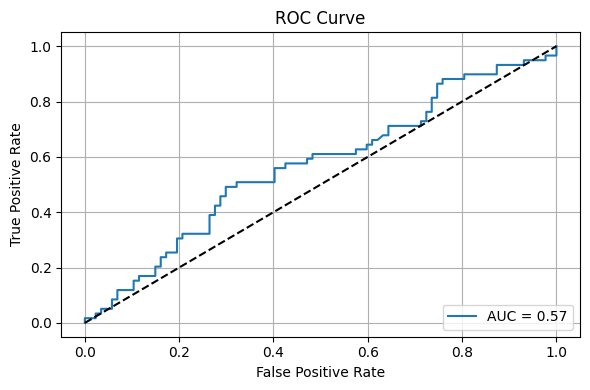

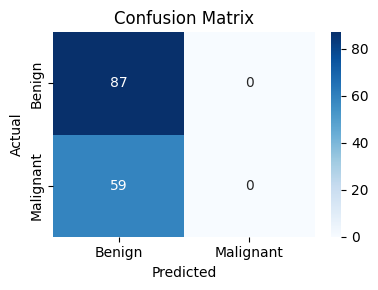

Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities and binary labels
y_pred_proba = dual_view_model.predict([cc_feature_vectors_test, mlo_feature_vectors_test])
y_pred = (y_pred_proba > 0.5).astype(int)

# AUC
test_auc = roc_auc_score(test_labels, y_pred_proba)
print(f"Test AUC: {test_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classifica


In [41]:
# Apply filtering
mass_train_paired = get_paired_samples(mass_train)
mass_test_paired = get_paired_samples(mass_test)

In [42]:
mass_train_paired.head()

AttributeError: 'tuple' object has no attribute 'head'

In [ ]:
# Split into CC and MLO views
mass_train_cc = mass_train_paired[mass_train_paired['image_view'] == 'CC'].copy()
mass_train_mlo = mass_train_paired[mass_train_paired['image_view'] == 'MLO'].copy()
mass_test_cc = mass_test_paired[mass_test_paired['image_view'] == 'CC'].copy()
mass_test_mlo = mass_test_paired[mass_test_paired['image_view'] == 'MLO'].copy()

In [ ]:
# Sort by patient_id to ensure alignment
mass_train_cc = mass_train_cc.sort_values('patient_id').reset_index(drop=True)
mass_train_mlo = mass_train_mlo.sort_values('patient_id').reset_index(drop=True)
mass_test_cc = mass_test_cc.sort_values('patient_id').reset_index(drop=True)
mass_test_mlo = mass_test_mlo.sort_values('patient_id').reset_index(drop=True)

In [ ]:
# Verify alignment
assert (mass_train_cc['patient_id'] == mass_train_mlo['patient_id']).all(), "Train patient IDs misaligned"
assert (mass_test_cc['patient_id'] == mass_test_mlo['patient_id']).all(), "Test patient IDs misaligned"

In [ ]:
# Check sample counts
print("Train CC samples:", len(mass_train_cc))
print("Train MLO samples:", len(mass_train_mlo))
print("Test CC samples:", len(mass_test_cc))
print("Test MLO samples:", len(mass_test_mlo))

# CC Pathway

In [ ]:
# filter to obtain only the CC views 

mass_train_cc = mass_train_paired[mass_train['image_view'] == 'CC'].copy()
mass_test_cc = mass_test_paired[mass_test['image_view'] == 'CC'].copy()


In [ ]:
mass_train_cc.head(3)

In [ ]:
mass_test_cc.head(3)

In [ ]:
mass_train_cc.pathology.value_counts()

In [ ]:
mass_test_cc.pathology.value_counts()

In [ ]:
plot_smaples(mass_train_cc['image_file_path'].values, row=15, col=15)


In [ ]:
plot_smaples(mass_test_cc['image_file_path'].values, row=15, col=15)

In [ ]:
# # given the outputs above the classes are relatively balanced ([296 vs 311 in training] and [67 vs 110 in testing]) 
# # no need of class balancing as of now

# Label Mapping and Verification

# Map pathology to binary labels (malignant = 1, benign and others ( benign_without_callback) = 0)
mass_train_cc['label'] = mass_train_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_cc['label'] = mass_test_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')

# Confirm distribution
print("Training label counts:\n", mass_train_cc['label'].value_counts())
print("Testing label counts:\n", mass_test_cc['label'].value_counts())



In [ ]:
# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_cc = train_datagen.flow_from_dataframe(
    dataframe=mass_train_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True
)

# Test generator
test_generator_cc = test_datagen.flow_from_dataframe(
    dataframe=mass_test_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

In [ ]:
# # for binary classification 


# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# # Step 1 - Load EfficientNetB0 as the base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Step 2 - Freeze the base model layers
# base_model.trainable = False  # Prevents pretrained weights from being updated

# # Step 3 - Build the classification model
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # Step 4 - Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Step 5 - Summary
# model.summary()


In [ ]:
# # for binary classification 


# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# # Step 1 - Load EfficientNetB0 as the base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Step 2 - Freeze the base model layers
# base_model.trainable = False  # Prevents pretrained weights from being updated

# # Step 3 - Build the classification model
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # Step 4 - Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Step 5 - Summary
# model.summary()


In [ ]:
# feature vectors model 

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D




def build_EffB0_feature_extractor_cc(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze last unfreeze_ratio% of layers (same as MLO)
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True
    
    x_cc = GlobalAveragePooling2D()(base_model.output)
    x_cc = Dense(512, activation='relu')(x_cc)
    x_cc =BatchNormalization()(x_cc)
    output = Dropout(0.4)(x_cc)


    # binary classification to check model performance ()
    # x_cc = Dropout(0.4)(x_cc)
    # output = Dense(1, activation='sigmoid')(x_cc)  #Binary classification
    
    # return Model(inputs=base_model.input, outputs=output)
    return Model(inputs=base_model.input, outputs=output, name='cc_feature_extractor')





# Build model
EffB0_model_cc = build_EffB0_feature_extractor_cc()
EffB0_model_cc.summary()

                              
                             

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     GlobalAveragePooling2D, 
#     Dense, 
#     Dropout, 
#     BatchNormalization,
#     LayerNormalization,
#     Concatenate
# )

# def build_improved_feature_extractor(img_size=(224, 224, 3)):
#     # Base model (EfficientNetB0, frozen)
#     base_model = EfficientNetB0(
#         input_shape=img_size, 
#         include_top=False, 
#         weights='imagenet',
#         pooling=None  # Explicitly no pooling to allow multi-level feature fusion
#     )
#     base_model.trainable = False  # Freeze pretrained weights

#     # Multi-level feature fusion (optional: concat GAP and GMP)
#     gap = GlobalAveragePooling2D()(base_model.output)
#     gmp = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)
#     fused_features = Concatenate()([gap, gmp])  # Combines avg and max pooled features

#     # Non-linear projection head (improves feature separation)
#     x = Dense(1024, activation='relu')(fused_features)
#     x = BatchNormalization()(x)  # Stabilizes training
#     x = Dropout(0.3)(x)
    
#     # L2-normalized output (critical for similarity tasks)
#     output = tf.keras.layers.Lambda(
#         lambda x: tf.math.l2_normalize(x, axis=1)
#     )(x)

#     return Model(inputs=base_model.input, outputs=output)

# # Build and verify
# model = build_improved_feature_extractor()
# model.summary()

In [ ]:
# # for binary classification 
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall, AUC
# import tensorflow_addons as tfa  # For F1 score

# EffB0_model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),
#         tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5, name='f1_score')
#     ]
# )


In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall, AUC

# EffB0_model_cc.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),
        
#     ]
# )

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Callbacks to stop training early if val_loss doesn't improve and to save best weights
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_effb0_model.h5', monitor='val_loss', save_best_only=True)

# # Train the model
# history_cc = EffB0_model_cc.fit(
#     train_generator_cc,
#     epochs=12,
#     validation_data=test_generator_cc,
#     callbacks=[early_stop, checkpoint]
# )

In [ ]:
# Just get the features
cc_feature_vectors_train = EffB0_model_cc.predict(train_generator_cc, verbose=1)
cc_feature_vectors_test = EffB0_model_cc.predict(test_generator_cc, verbose=1)

In [ ]:
np.save("cc_feature_vectors_train.npy", cc_feature_vectors_train)
np.save("cc_feature_vectors_test.npy", cc_feature_vectors_test)


## Evaluate Feature Vectors

# MLO Pathway 

In [ ]:
# filter to obtain only the MLO views 

mass_train_mlo = mass_train[mass_train['image_view'] == 'MLO'].copy()
mass_test_mlo = mass_test[mass_test['image_view'] == 'MLO'].copy()

In [ ]:
mass_train_mlo.head(3)

In [ ]:
mass_test_mlo.head(3)

In [ ]:
mass_train_mlo.pathology.value_counts()

In [ ]:
mass_test_mlo.pathology.value_counts()

In [ ]:
# # given the outputs above the classes are relatively balanced ([341 vs 370 in training] and [100 vs 80 in testing]) 
# # no need of class balancing as of now

# Label Mapping and Verification

# Map pathology to binary labels (malignant = 1, benign and others ( benign_without_callback) = 0)
mass_train_mlo['label'] = mass_train_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_mlo['label'] = mass_test_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')

# Confirm distribution
print("Training label counts:\n", mass_train_mlo['label'].value_counts())
print("Testing label counts:\n", mass_test_mlo['label'].value_counts())

In [ ]:
plot_smaples(mass_test_mlo['image_file_path'].values, row=15, col=15)

In [ ]:
plot_smaples(mass_train_mlo['image_file_path'].values, row=15, col=15)

In [ ]:
# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_mlo = train_datagen.flow_from_dataframe(
    dataframe=mass_train_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True
)



# Test generator
test_generator_mlo = test_datagen.flow_from_dataframe(
    dataframe=mass_test_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

In [ ]:
def build_EffB0_feature_extractor_mlo(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.models import Model

    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last unfreeze_ratio% of layers
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True

    # Classification head
    x_mlo = GlobalAveragePooling2D()(base_model.output)
    x_mlo = Dense(512, activation='relu')(x_mlo)
    x_mlo =BatchNormalization()(x_mlo)  # Normalizes 512 features
    output = Dropout(0.4)(x_mlo)
    
    
    # binary classification to check model performance ()
    # x_mlo = Dropout(0.4)(x_mlo)
    # output = Dense(1, activation='sigmoid')(x_mlo)  #Binary classification

    # return Model(inputs=base_model.input, outputs=output)
    
    return Model(inputs=base_model.input, outputs=output, name='mlo_feature_extractor')


# Build model
EffB0_model_mlo = build_EffB0_feature_extractor_mlo()
EffB0_model_mlo.summary()

In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall, AUC

# EffB0_model_mlo.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),
        
#     ]
# )


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Callbacks to stop training early if val_loss doesn't improve and to save best weights
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_effb0_model.h5', monitor='val_loss', save_best_only=True)

# # Train the model
# history_mlo = EffB0_model_mlo.fit(
#     train_generator_mlo,
#     epochs=10,
#     validation_data=test_generator_mlo,
#     callbacks=[early_stop, checkpoint]
# )

In [ ]:
# Just get the features
mlo_feature_vectors_train = EffB0_model_mlo.predict(train_generator_mlo, verbose=1)
mlo_feature_vectors_test = EffB0_model_mlo.predict(test_generator_mlo, verbose=1)

In [ ]:
np.save("mlo_feature_vectors_train.npy", mlo_feature_vectors_train)
np.save("mlo_feature_vectors_test.npy", mlo_feature_vectors_test)

# Dual-View Model  Claude


In [ ]:
def build_dual_view_model(img_size=(224, 224, 3), num_classes=1):  # Binary = 1 output
    # Create feature extractors
    cc_extractor = build_EffB0_feature_extractor_cc(img_size)
    mlo_extractor = build_EffB0_feature_extractor_mlo(img_size)
    
    # Inputs for both views
    cc_input = Input(shape=img_size, name='cc_input')
    mlo_input = Input(shape=img_size, name='mlo_input')
    
    # Extract features from both pathways
    cc_features = cc_extractor(cc_input)
    mlo_features = mlo_extractor(mlo_input)
    
    # Fuse features
    fused_features = Concatenate(name='feature_fusion')([cc_features, mlo_features])
    
    # Classification head
    x = Dense(256, activation='relu')(fused_features)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid', name='prediction')(x)  # Binary classification
    
    # Create the complete model
    dual_model = Model(
        inputs=[cc_input, mlo_input], 
        outputs=output,
        name='dual_view_mammogram_classifier'
    )
    
    return dual_model

In [ ]:
# 3. DATA PREPARATION FOR DUAL-VIEW
def create_paired_dataset(mass_train_cc, mass_train_mlo, mass_test_cc, mass_test_mlo):
    """
    Create paired CC-MLO dataset for dual-view training
    """
    # Merge CC and MLO data on patient_id and breast side
    train_paired = pd.merge(
        mass_train_cc[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        mass_train_mlo[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        on=['patient_id', 'left_or_right_breast'],
        suffixes=('_cc', '_mlo')
    )
    
    test_paired = pd.merge(
        mass_test_cc[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        mass_test_mlo[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        on=['patient_id', 'left_or_right_breast'],
        suffixes=('_cc', '_mlo')
    )
    
    # Ensure labels match (they should for same patient/breast)
    train_paired = train_paired[train_paired['label_cc'] == train_paired['label_mlo']]
    test_paired = test_paired[test_paired['label_cc'] == test_paired['label_mlo']]
    
    print(f"Paired training samples: {len(train_paired)}")
    print(f"Paired testing samples: {len(test_paired)}")
    
    return train_paired, test_paired


In [ ]:
class DualViewDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paired_df, batch_size=32, img_size=(224, 224), shuffle=True, augment=False):
        super().__init__()  # This fixes the warning
        self.paired_df = paired_df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.paired_df))
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.paired_df) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.paired_df.iloc[batch_indices]
    
        cc_images = []
        mlo_images = []
        labels = []

        for _, row in batch_df.iterrows():
            cc_img = tf.keras.preprocessing.image.load_img(row['cropped_image_file_path_cc'], target_size=self.img_size)
            cc_img = tf.keras.preprocessing.image.img_to_array(cc_img) / 255.0
        
            mlo_img = tf.keras.preprocessing.image.load_img(row['cropped_image_file_path_mlo'], target_size=self.img_size)
            mlo_img = tf.keras.preprocessing.image.img_to_array(mlo_img) / 255.0
        
            cc_images.append(cc_img)
            mlo_images.append(mlo_img)
            labels.append(float(row['label_cc']))
            
        return {'cc_input': np.array(cc_images),
                'mlo_input': np.array(mlo_images)}, np.array(labels)

    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
def train_dual_view_model():
    # Create paired datasets
    train_paired, test_paired = create_paired_dataset(
        mass_train_cc, mass_train_mlo, mass_test_cc, mass_test_mlo
    )
    
    # Create data generators
    train_generator = DualViewDataGenerator(
        train_paired, 
        batch_size=32, 
        shuffle=True, 
        augment=True
    )
    
    test_generator = DualViewDataGenerator(
        test_paired, 
        batch_size=32, 
        shuffle=False, 
        augment=False
    )
    
    # Build and compile model
    dual_view_model = build_dual_view_model()
    dual_view_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    # Training callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_dual_view_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
    
    # Train the model
    history = dual_view_model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50,
        callbacks=callbacks
    )
    
    return dual_view_model, history    

In [ ]:
# Don't compile individual extractors - just build the dual-view model
print("Building dual-view model...")
dual_view_model = build_dual_view_model()
dual_view_model.summary()

# Train the complete model
# model, history = train_dual_view_model()

In [ ]:
# train model 
model, history = train_dual_view_model()

# GROK

# Dual View CHATGPT

In [ ]:
# from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
# from tensorflow.keras.models import Model

# def build_dual_input_fusion_model(cc_model, mlo_model):
#     # Freeze the feature extractor parts of both models
#     cc_model.trainable = False
#     mlo_model.trainable = False

#     # Define separate inputs for CC and MLO images
#     input_cc = Input(shape=(224, 224, 3), name='cc_input')
#     input_mlo = Input(shape=(224, 224, 3), name='mlo_input')

#     # Get the feature vectors from both pathways
#     features_cc = cc_model(input_cc)   # shape: (None, 512)
#     features_mlo = mlo_model(input_mlo)

#     # Concatenate feature vectors
#     concatenated = Concatenate()([features_cc, features_mlo])  # shape: (None, 1024)

#     # Add classification head
#     x = Dense(256, activation='relu')(concatenated)
#     x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     output = Dense(1, activation='sigmoid')(x)  # Binary output

#     # Create model
#     fusion_model = Model(inputs=[input_cc, input_mlo], outputs=output, name='EfficientViewNet')

#     return fusion_model


In [ ]:
# # Assume you have these models from your previous code
# # EffB0_model_cc = build_EffB0_binary_cc()
# # EffB0_model_mlo = build_EffB0_binary_mlo()

# fusion_model = build_dual_input_fusion_model(EffB0_model_cc, EffB0_model_mlo)
# fusion_model.summary()


In [ ]:
# fusion_model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),]
        
# )


In [ ]:
# history_fusion = fusion_model.fit(


    
# )

In [ ]:
print(f"cc_feature_vectors_train shape: {cc_feature_vectors_train.shape}")
print(f"mlo_feature_vectors_train shape: {mlo_feature_vectors_train.shape}")
print(f"cc_feature_vectors_test shape: {cc_feature_vectors_test.shape}")
print(f"mlo_feature_vectors_test shape: {mlo_feature_vectors_test.shape}")
    

In [ ]:
# Assuming you have a DataFrame with metadata
common_ids = np.intersect1d(mass_train_cc['image_id'], mass_train_mlo['image_id'])
cc_mask = mass_train_cc['image_id'].isin(common_ids)
mlo_mask = mass_train_mlo['image_id'].isin(common_ids)

# Filter feature vectors and labels
cc_feature_vectors_train = cc_feature_vectors_train[cc_mask]
mlo_feature_vectors_train = mlo_feature_vectors_train[mlo_mask]
y_train = mass_train_cc[cc_mask]['label'].astype('int').values

# Verify shapes after filtering
print("Filtered cc_feature_vectors_train shape:", cc_feature_vectors_train.shape)
print("Filtered mlo_feature_vectors_train shape:", mlo_feature_vectors_train.shape)

In [ ]:
# concantenate the features
X_train_combined = np.concatenate([cc_feature_vectors_train, mlo_feature_vectors_train], axis=1)
X_test_combined = np.concatenate([cc_feature_vectors_test, mlo_feature_vectors_test], axis=1)

# Get labels as integers (0 or 1)
y_train = mass_train_cc['label'].astype('int').values
y_test = mass_test_cc['label'].astype('int').values